In [ ]:
# Using LORA using imagenet

In [ ]:
#!pip install torchvision torch

In [27]:
#!pip install datasets

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from torch.optim import Adam

In [3]:
from datasets import load_dataset

dataset = load_dataset("food101")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [4]:
# Print the number of labels/classes in the dataset
num_labels = len(dataset['train'].features['label'].names)
print(f'Number of labels in the dataset: {num_labels}')

Number of labels in the dataset: 101


Found label 1 / 10: beignets
Found label 2 / 10: prime_rib
Found label 3 / 10: ramen
Found label 4 / 10: hamburger
Found label 5 / 10: bruschetta
Found label 6 / 10: chicken_wings
Found label 7 / 10: pork_chop
Found label 8 / 10: greek_salad
Found label 9 / 10: sashimi
Found label 10 / 10: risotto


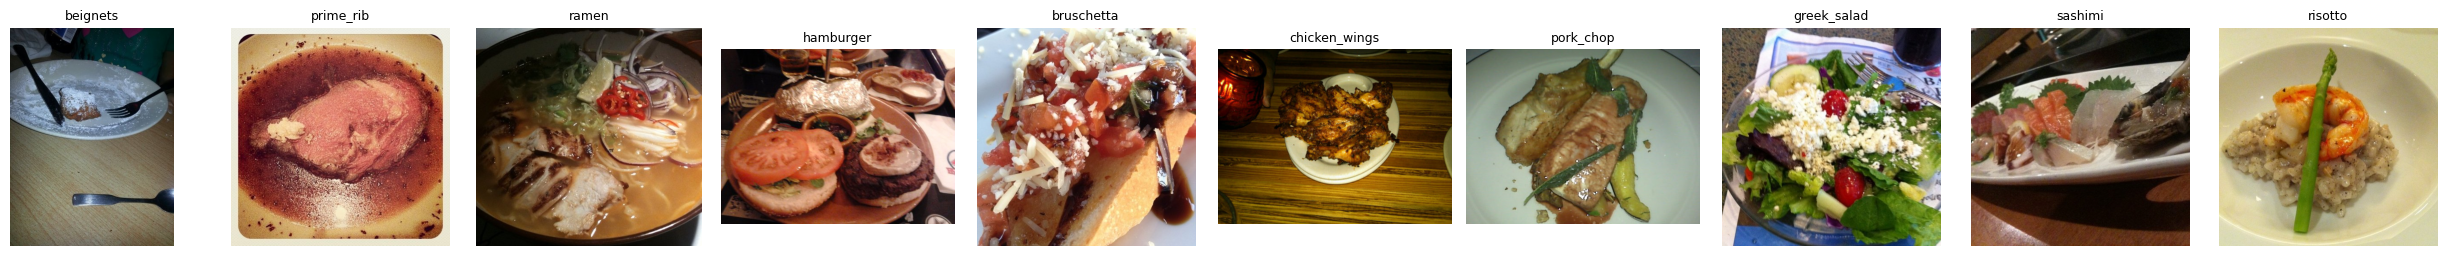

In [5]:
import matplotlib.pyplot as plt

# Updated function to display one image per label, with logging, limited to the first 20 images
def show_limited_images_per_label(dataset, limit=20):
    plt.figure(figsize=(25, 5))  # Adjust figure size for 10 images per row
    found_labels = set()
    img_count = 0

    for example in dataset:
        label = example['label']
        if label not in found_labels:
            found_labels.add(label)
            img_count += 1
            # Log the finding
            print(f"Found label {len(found_labels)} / {limit}: {dataset.features['label'].names[label]}")

            # Calculate position for subplot
            ax = plt.subplot(2, 10, img_count)  # Assuming 2 rows, 10 cols for the first 20 images
            image = example['image']
            ax.imshow(image)  # Display the image
            ax.set_title(f"{dataset.features['label'].names[label]}", fontsize=9)
            ax.axis('off')

            # Stop if we've reached the limit
            if img_count == limit:
                break

    plt.tight_layout()
    plt.show()

# Display the first 20 images, one per label, with logging
show_limited_images_per_label(dataset['train'], limit=10)

# Select 5 Labels, and proceed with a smaller sampled dataset

In [6]:
# Select 5 labels (the first 5 labels)
selected_labels = range(5)

# Filter dataset for examples with selected labels only
filtered_dataset = dataset['train'].filter(lambda example: example['label'] in selected_labels)

Filter:   0%|          | 0/75750 [00:00<?, ? examples/s]

In [7]:
# Shuffle the filtered dataset to ensure randomness
shuffled_dataset = filtered_dataset.shuffle(seed=42)

# Partition the shuffled dataset
def partition_dataset(dataset, train_size=300, val_size=20, test_size=50):
    train, val, test = [], [], []
    counts = {label: {'train': 0, 'val': 0, 'test': 0} for label in selected_labels}

    for example in dataset:
        label = example['label']
        if counts[label]['train'] < train_size:
            train.append(example)
            counts[label]['train'] += 1
        elif counts[label]['val'] < val_size:
            val.append(example)
            counts[label]['val'] += 1
        elif counts[label]['test'] < test_size:
            test.append(example)
            counts[label]['test'] += 1
        # Stop if all partitions are filled for this label
        if all(counts[label][part] >= size for part, size in zip(['train', 'val', 'test'], [train_size, val_size, test_size])):
            continue  # Move to next example if more labels need processing

    return train, val, test

# Apply partitioning and select from each label
train, val, test = partition_dataset(shuffled_dataset, train_size=300, val_size=20, test_size=50)

In [8]:
# Validate sizes
print(f"Total training examples: {len(train)}")
print(f"Total validation examples: {len(val)}")
print(f"Total test examples: {len(test)}")

Total training examples: 1500
Total validation examples: 100
Total test examples: 250


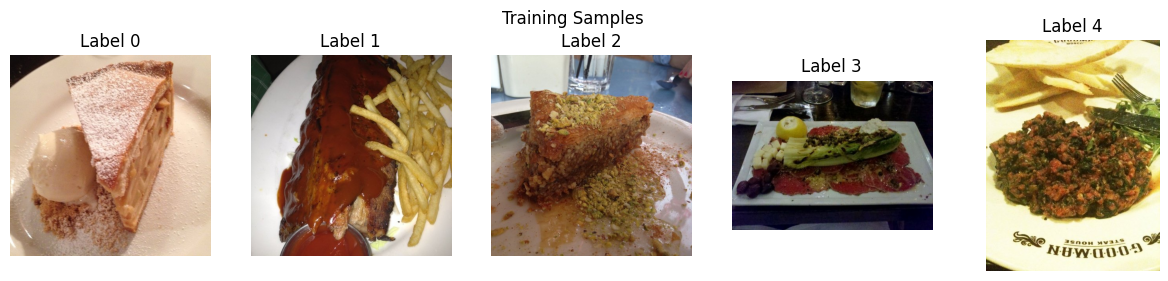

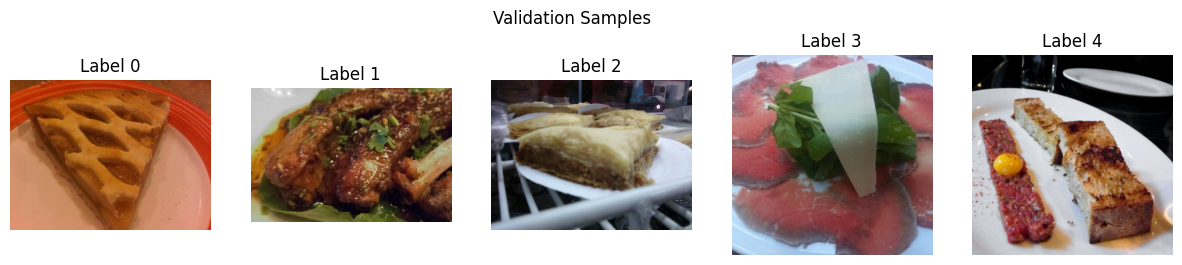

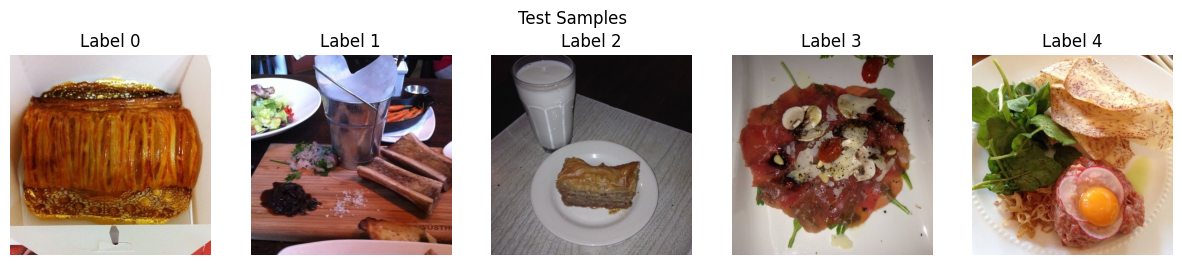

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

def display_samples(dataset, title):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)
    for i, label in enumerate(range(5)):
        for example in dataset:
            if example['label'] == label:
                image = example['image']
                plt.subplot(1, 5, i + 1)
                plt.imshow(image)
                plt.title(f"Label {label}")
                plt.axis('off')
                break  # Move to the next label after one example is found
    plt.show()

# Display samples from each set
display_samples(train, "Training Samples")
display_samples(val, "Validation Samples")
display_samples(test, "Test Samples")

In [10]:
# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Number of features in the input of the last layer
num_ftrs = model.fc.in_features
print('num_ftrs:', num_ftrs)

# Modify the last layer for 5 classes and apply LORA
model.fc = nn.Linear(num_ftrs, 5)  # Adjust if your dataset has a different number of classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s]


num_ftrs: 512


In [11]:
# Define LORA adaptation (simplified example)
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        # Assuming adaptation applies to a linear layer
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

In [12]:
# Apply LORA to the last layer
model.fc = LORALayer(model.fc)

In [23]:
from torch.utils.data import DataLoader, Dataset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 expects 224x224 images
    transforms.ToTensor()
])


# Example custom dataset class
class CustomDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']  # Load image
        image = transform(image)  # Apply necessary transformations
        label = example['label']
        return image, label

# Initialize datasets
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
from torch.optim import lr_scheduler


num_epochs = 20

# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)


# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_running_loss / len(val_loader)}, Val Accuracy: {val_accuracy}%')

Epoch 1, Train Loss: 3.7094006065992597, Train Accuracy: 45.53333333333333%, Val Loss: 3.6298733949661255, Val Accuracy: 53.0%
Epoch 2, Train Loss: 1.7421091718876616, Train Accuracy: 54.6%, Val Loss: 1.2043009474873543, Val Accuracy: 46.0%
Epoch 3, Train Loss: 1.184404122702619, Train Accuracy: 65.8%, Val Loss: 1.1880044341087341, Val Accuracy: 69.0%
Epoch 4, Train Loss: 1.754223178041742, Train Accuracy: 64.8%, Val Loss: 28.22611093521118, Val Accuracy: 35.0%
Epoch 5, Train Loss: 2.5063782549918967, Train Accuracy: 49.6%, Val Loss: 1.4190873801708221, Val Accuracy: 48.0%
Epoch 6, Train Loss: 1.5146250255564426, Train Accuracy: 58.53333333333333%, Val Loss: 0.9150730185210705, Val Accuracy: 60.0%
Epoch 7, Train Loss: 1.2718843830392716, Train Accuracy: 62.53333333333333%, Val Loss: 0.8249746933579445, Val Accuracy: 69.0%
Epoch 8, Train Loss: 0.7853724163897494, Train Accuracy: 72.2%, Val Loss: 0.7029658108949661, Val Accuracy: 73.0%
Epoch 9, Train Loss: 1.0794161919583665, Train Accur

In [25]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model to disk
torch.save(model.state_dict(), 'best_model.pth')

Test Accuracy: 72.4%


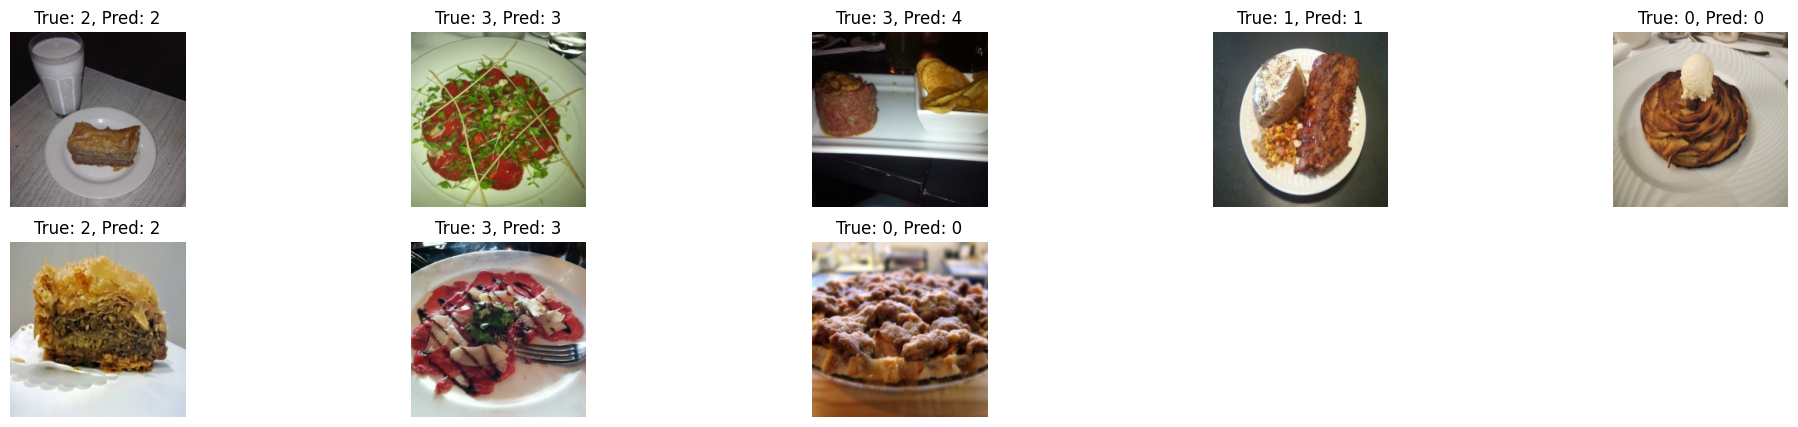

In [26]:
# Test phase (after training is complete and best model is loaded)
model.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()
